In [1]:
using Plots

# Gaussian distribution

In [2]:
gauss_function(
    x::Float64,
    μ::Float64,
    σ::Float64
)::Float64 = let
    Z = sqrt(2π)*σ
    exp(-(x - μ)^2 / (2σ^2)) / Z
end


abstract type Distribution end

struct Gaussian <: Distribution
    μ::Float64
    σ::Float64
end

(p::Gaussian)(
    x::Float64
)::Float64 =
    gauss_function(x, p.μ, p.σ)

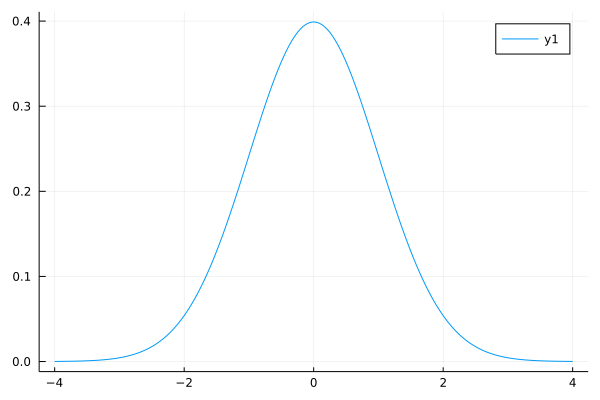

In [3]:
std_gauss = Gaussian(0., 1.)

x = [i for i = -4:0.01:4]
plot(x, std_gauss.(x))

# Mixture of Gaussian distribution

In [4]:
struct GaussianMixture <: Distribution
    π::Array{Float64, 1}
    gaussians::Array{Gaussian, 1}
    
    GaussianMixture(
        π::Array{Float64, 1},
        μ::Array{Float64, 1},
        σ::Array{Float64, 1}
    ) = new(π, [Gaussian(μi, σi) for (μi, σi) = zip(μ, σ)])
end

(p::GaussianMixture)(
    x::Float64
)::Float64 =
    sum([
        πi * gaussian.(x)
        for (πi, gaussian) = zip(p.π, p.gaussians)
    ])

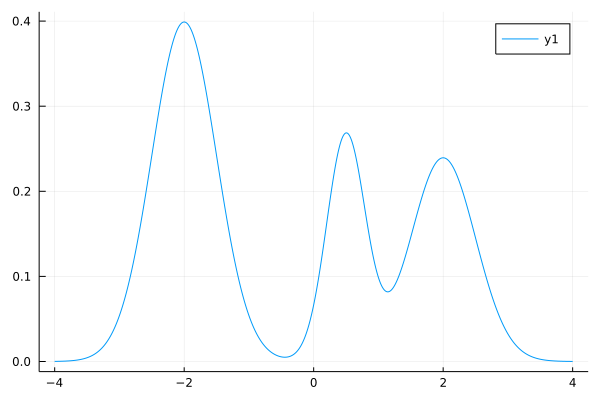

In [5]:
gauss_mix3 = GaussianMixture(
    [0.5, 0.2, 0.3],
    [-2., 0.5, 2.],
    [0.5, 0.3, 0.5]
)

plot(x, gauss_mix3.(x))

# Sampling function

1000000
0.0014491586159829464


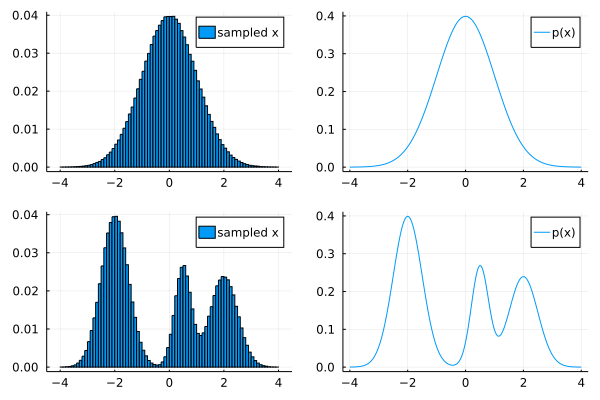

In [6]:
function sample(
    p::Distribution,
    n::Int64,
    upper_bound::Float64,
    lower_bound::Float64,
)::Array{Float64, 1}
    x_samples = zeros(n)
    i = 0
    while i < n
        x_ = (upper_bound - lower_bound) * rand() + lower_bound
        if rand() < p(x_)
            i += 1
            x_samples[i] = x_
        end
    end
    x_samples
end

x_std_gauss = sample(std_gauss, 1_000_000, -4., 4.)
println(length(x_std_gauss))
println(sum(x_std_gauss)/1_000_000)

h1 = histogram(x_std_gauss, normalize=:probability, bins=100, label="sampled x")
p1 = plot(x, std_gauss.(x), label="p(x)")

x_gauss_mix3 = sample(gauss_mix3, 1_000_000, -4., 4.)
h2 = histogram(x_gauss_mix3, normalize=:probability, bins=100, label="sampled x")
p2 = plot(x, gauss_mix3.(x), label="p(x)")
plot(h1, p1, h2, p2)

# Histgram density estimation

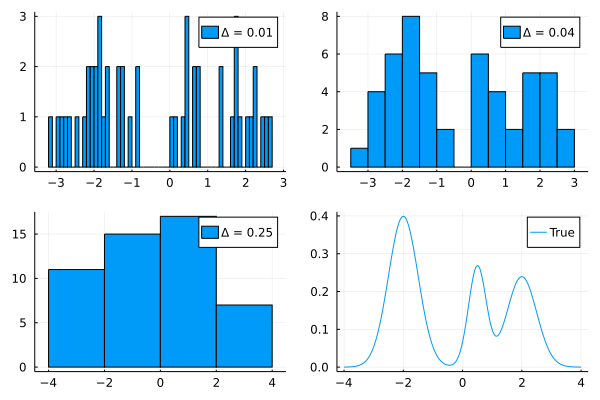

In [7]:
lower_bound, upper_bound = -4., 4.
x_observed = sample(gauss_mix3, 50, lower_bound, upper_bound)

hs = [
    histogram(x_observed, bins=round(Int, 1/Δ), label="Δ = " * string(Δ))
    for Δ = [0.01, 0.04, 0.25]
]

p = plot(x, gauss_mix3.(x), label="True")

plot(hs..., p)

# Kernel density estimation 

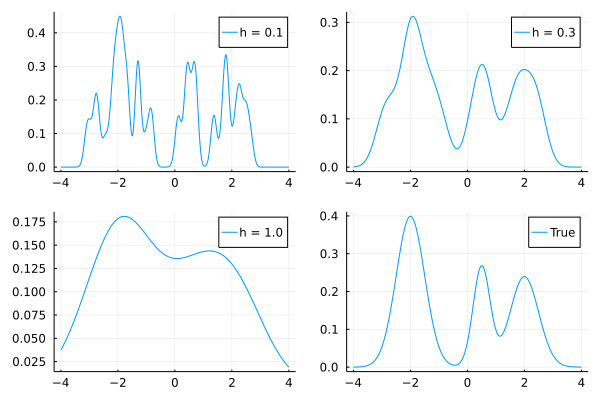

In [8]:
abstract type Kernel end

struct GaussianKernel <: Kernel
    h::Float64
end

(k::GaussianKernel)(
    x1::Float64,
    x2::Float64
) = gauss_function(x1, x2, k.h)


struct KernelDensityModel <: Distribution
    kernel::Kernel
    x::Array{Float64, 1}
end

(p::KernelDensityModel)(
    x::Float64
)::Float64 = sum([p.kernel(x, x_) for x_ = p.x]) / length(p.x)

ps = [
    let 
        gauss_kernel = GaussianKernel(h)
        gauss_density_estimator = KernelDensityModel(gauss_kernel, x_observed)
        plot(x, gauss_density_estimator.(x), label="h = " * string(h))
    end
    for h = [0.1, 0.3, 1.]
]

p = plot(x, gauss_mix3.(x), label="True")

plot(ps..., p)

# K-nearest neigbor density estimation 

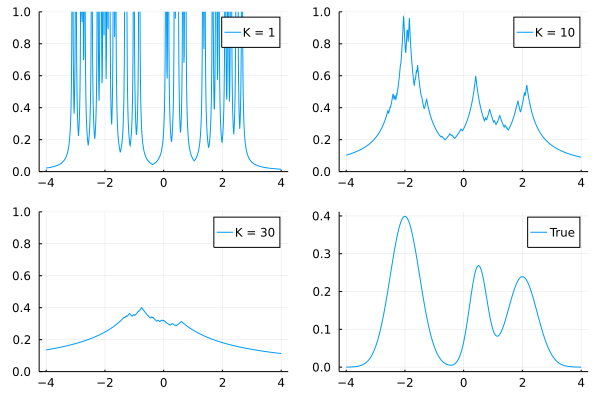

In [9]:
struct KNNDensityModel <: Distribution
    K::Int64
    x::Array{Float64, 1}
end

(p::KNNDensityModel)(
    x::Float64
)::Float64 = let
    ds = abs.(p.x .- x)
    p.K / (length(p.x) * sort(ds)[p.K])
end

ps = [
    let
        knn_density_estimator = KNNDensityModel(K, x_observed)
        plot(x, knn_density_estimator.(x), label="K = " * string(K), ylims=(0, 1.))
    end
    for K = [1, 10, 30]
]
p = plot(x, gauss_mix3.(x), label="True")
plot(ps..., p)